# Introduction

This notebook demonstrates zero-shot object detection by integrating OpenAI's CLIP (Contrastive Language-Image Pretraining) model with a Region Proposal Network (RPN) from Faster R-CNN. Zero-shot object detection enables the identification and localization of objects within an image based solely on textual descriptions, without any task-specific training.

**Overview of the Approach:**

1. **Region Proposal**: Use the RPN from Faster R-CNN to generate candidate regions that may contain objects.
2. **Embedding Generation**: Encode the candidate image regions and textual queries into high-dimensional embeddings using CLIP.
3. **Similarity Computation**: Calculate the cosine similarity between image region embeddings and text embeddings to evaluate matches.
4. **Object Detection**: Detect and localize objects by selecting regions with the highest similarity scores relative to the textual descriptions.

Leveraging CLIP's capability to associate images with textual concepts allows us to perform object detection on any object described by text, without explicit training on those specific objects.

Let's dive in and see how CLIP can be harnessed for zero-shot object detection.

# Imports

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

In [1]:
import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

import clip

# Config

In [2]:
IMAGE_URL = "https://raw.githubusercontent.com/deepmancer/clip-object-detection/main/assets/original_image.png"

CLIP_BACKBONE = "ViT-B/16"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FIGURE_SIZE = (8, 6)

# Data Loading

## Image Loading

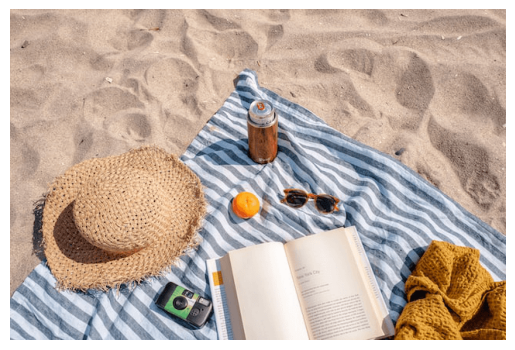

In [3]:
def fetch_image(url_or_path: str) -> Image.Image:
    if 'http' in url_or_path:
        response = requests.get(url_or_path)
        return Image.open(BytesIO(response.content)).convert("RGB")
    return Image.open(url_or_path)

image = fetch_image(IMAGE_URL)
plt.imshow(image)
plt.axis("off")
plt.show()

## Model Loading

### Faster R-CNN

In [4]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights="DEFAULT",
)
faster_rcnn.eval()

print("Faster R-CNN model loaded successfully!")

Faster R-CNN model loaded successfully!


### CLIP

In [5]:
clip_model, clip_preprocess = clip.load(CLIP_BACKBONE, device=DEVICE)
print(f"CLIP model with {CLIP_BACKBONE} backbone loaded successfully!")

CLIP model with ViT-B/16 backbone loaded successfully!


# Extracting Candidate Regions

For this part, use the `RegionProposalNetwork` from a pretrained Faster R-CNN model to extract candidate regions for different objects. Then, visualize all the bounding boxes. The resulting image should look similar to the example below:

<div style="text-align: center;">
    <figure>
        <img src="https://raw.githubusercontent.com/deepmancer/clip-object-detection/main/assets/regions.png" alt="Faster R-CNN Candidate Regions">
        <figcaption>Faster R-CNN Candidate Regions</figcaption>
    </figure>
</div>

In [6]:
def compute_faster_rcnn_result(image: Image.Image) -> dict:
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image_pt = transform(image)
    transformed = faster_rcnn.transform([image_pt])[0]
    features = faster_rcnn.backbone(transformed.tensors)

    all_region_proposal_boxes = faster_rcnn.rpn(transformed, features)[0][0]
    frcnn_outputs = faster_rcnn(image_pt.unsqueeze(0))[0]

    return {
        "all_region_proposal_boxes": all_region_proposal_boxes,
        "candidates": frcnn_outputs,
    }

frcnn_result = compute_faster_rcnn_result(image)
all_region_proposals = frcnn_result['all_region_proposal_boxes'].detach()
candidates_data = frcnn_result['candidates']

candidate_boxes = candidates_data['boxes'].detach()
candidate_scores = candidates_data['scores'].detach()

print(f"Total number of region proposal boxes: {all_region_proposals.shape[0]}")
print(f"Total number of candidate boxes: {candidate_boxes.shape[0]}")



Total number of region proposal boxes: 924
Total number of candidate boxes: 17


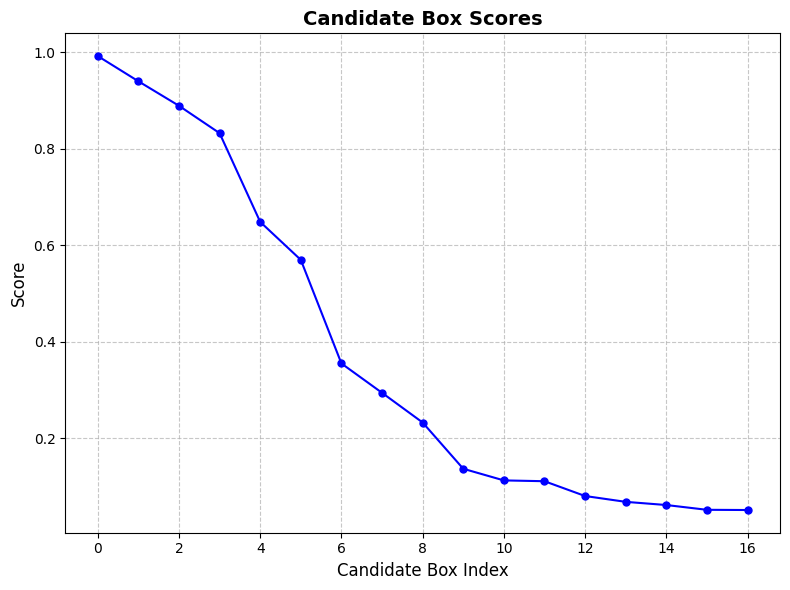

In [7]:
def plot_candidate_scores(candidate_scores: torch.Tensor) -> None:
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(candidate_scores.cpu().numpy(), marker="o", linestyle='-', color='b', markersize=5, linewidth=1.5)
    plt.xlabel("Candidate Box Index", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title("Candidate Box Scores", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    
plot_candidate_scores(candidate_scores)


In [8]:
def plot_image_with_boxes(image, boxes, labels=None, figsize=FIGURE_SIZE):
    fig, ax = plt.subplots(1, figsize=figsize)
    
    ax.imshow(image)
    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        ax.add_patch(rect)

        if labels is not None:
            label_size = len(labels[i]) * 10
            ax.text(
                x_min + (x_max - x_min) / 2 - label_size / 2,
                y_min - 10,
                labels[i],
                fontsize=12,
                verticalalignment="top",
                color="white",
                bbox=dict(facecolor="green", alpha=0.5, edgecolor="none"),
            )

    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()

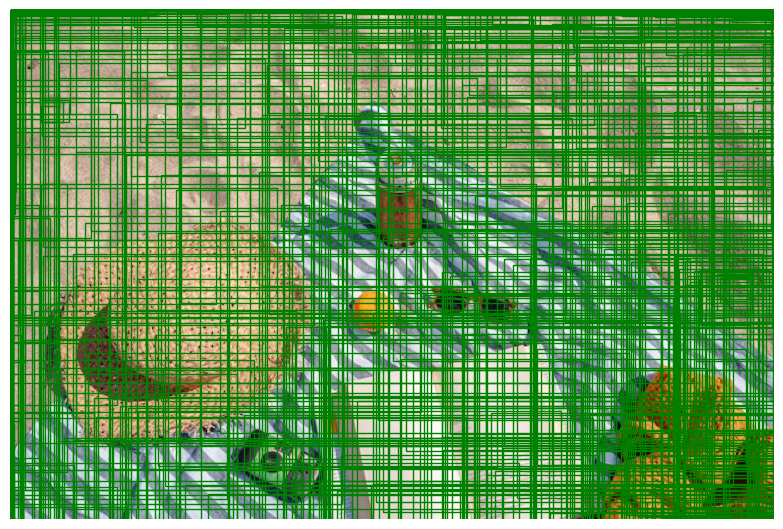

In [9]:
plot_image_with_boxes(image, all_region_proposals)

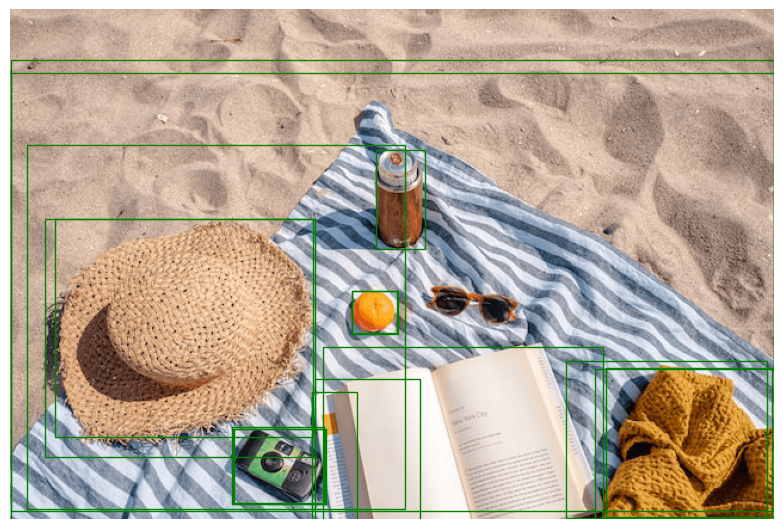

In [10]:
plot_image_with_boxes(image, candidate_boxes)

# Object Detection
At this stage, you will perform object detection using the extracted candidate regions and textual queries. The goal is to identify the objects described in the queries within the candidate regions. The process involves the following steps:


1. Extract the CLIP representation of candidate regions and query text.
2. Use an ensemble of prompts for your query to achieve better results:
   - For each query, write multiple similar prompts as shown in the example.
   - Average the embeddings of all prompts to obtain a representation of your query.
3. Compute the cosine similarity between the query and region candidates.
4. Return the most likely match.
5. Perform this process for all the queries specified below.
6. Save the results in the notebook.

In [11]:
tensor_transform = transforms.ToTensor()
image_pt = tensor_transform(image)

In [12]:
def detect_object_coordinates(model, processor, prompts, image_pt, boxes, device=DEVICE):
    height, width = image_pt.shape[-2:]
    
    max_similarity = -np.inf
    max_rel_box = None
    model.eval()
    
    tokenized_query = clip.tokenize(prompts).to(device)
    text_features = model.encode_text(tokenized_query)
    norm_text_features = F.normalize(text_features, p=2, dim=-1).mean(dim=0, keepdim=True)

    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        x_max, y_max = min(width, x_max), min(height, y_max)

        if x_min > x_max or x_min > width or y_min > y_max or y_min > height:
            continue

        cropped_image = image_pt[:, y_min:y_max+1, x_min:x_max+1]
        if not torch.prod(torch.tensor(cropped_image.shape)):
            continue

        cropped_image = processor(transforms.functional.to_pil_image(cropped_image)).unsqueeze(0).to(device)
        
        image_features = model.encode_image(cropped_image)
        norm_image_features = F.normalize(image_features, p=2, dim=-1)

        similarity = torch.dot(norm_image_features.view(-1), norm_text_features.view(-1))
        
        if similarity > max_similarity:
            max_similarity = similarity
            max_rel_box = box
    
    return max_rel_box.cpu().numpy() if max_rel_box is not None else None

In [14]:
labels = ['hat', 'camera', 'book', 'orange', 'drink', 'scarf']

label_prompts = {
    'hat': [
        'a hat',
        'a photo of a straw hat',
        'a woven straw hat',
        'a picture of a sun hat',
        'a wide-brimmed hat on the sand',
        'a beige beach hat',
        'a close-up of a straw boater hat',
        'a sun hat resting on a striped blanket',
        'a casual summer hat',
    ],
    'camera': [
        'a camera',
        'a photo of a disposable camera',
        'a small green and black film camera',
        'a vintage disposable camera',
        'a point-and-shoot camera on a beach blanket',
        'a retro film camera',
        'a handheld camera',
        'a portable beach camera',
        'a classic disposable camera for photography',
    ],
    'book': [
        'a book',
        'a photo of an open book',
        'a novel opened on a striped blanket',
        'a casual read at the beach',
        'an open book lying on a beach blanket',
        'a paperback novel with visible text',
        'a beach book with its pages open',
        'a leisure read resting on a blanket',
    ],
    'orange': [
        'an orange',
        'a photo of a citrus fruit',
        'a bright orange fruit',
        'a ripe orange on a blanket',
        'an orange fruit in the middle of the scene',
        'a single orange placed on a striped blanket',
        'a juicy orange ready to eat',
        'a fresh orange lying next to sunglasses',
        'a healthy snack for the beach',
    ],
    'drink': [
        'a drink',
        'a photo of a canned drink',
        'a metallic can of orange soda',
        'a refreshing drink can for the beach',
        'a chilled soda can with an orange label',
        'an aluminum can resting on a beach blanket',
        'a beverage can reflecting sunlight',
        'a canned drink placed at the top of the blanket',
        'a soft drink for a sunny day',
    ],
    'scarf': [
        'a scarf',
        'a photo of an orange scarf',
        'a patterned scarf on a beach blanket',
        'a lightweight scarf for the summer',
        'a casual beach scarf',
        'a vibrant scarf on a striped blanket',
        'an ariel view of a scarf on a blanket',
        'an orange-colored scarf for the summer',
    ],
}


Detecting hat...


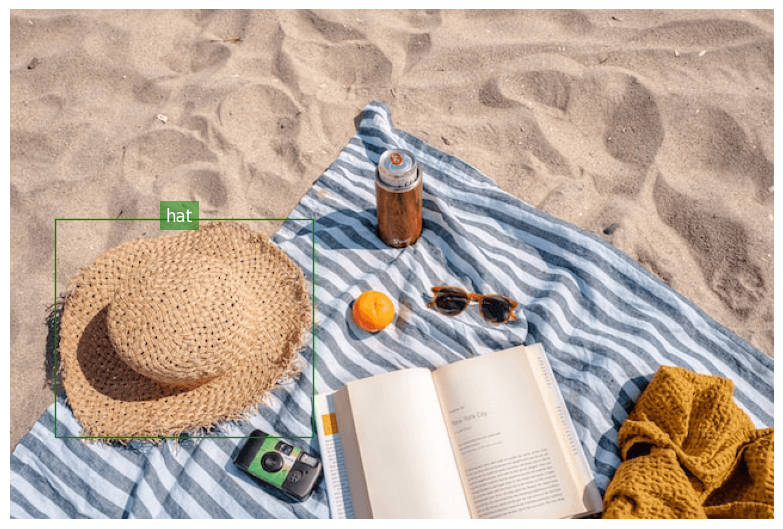

Detecting camera...


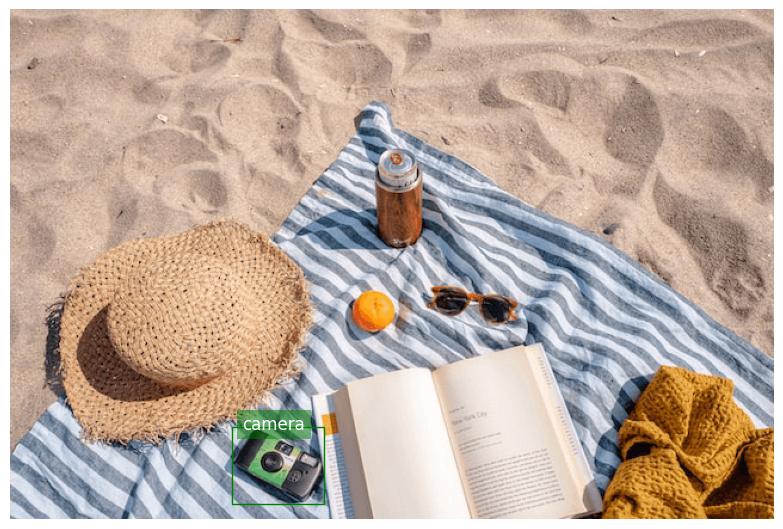

Detecting book...


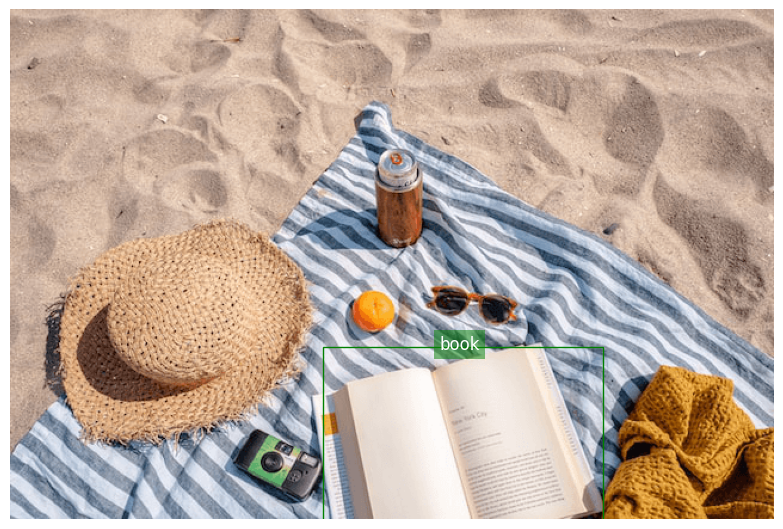

Detecting orange...


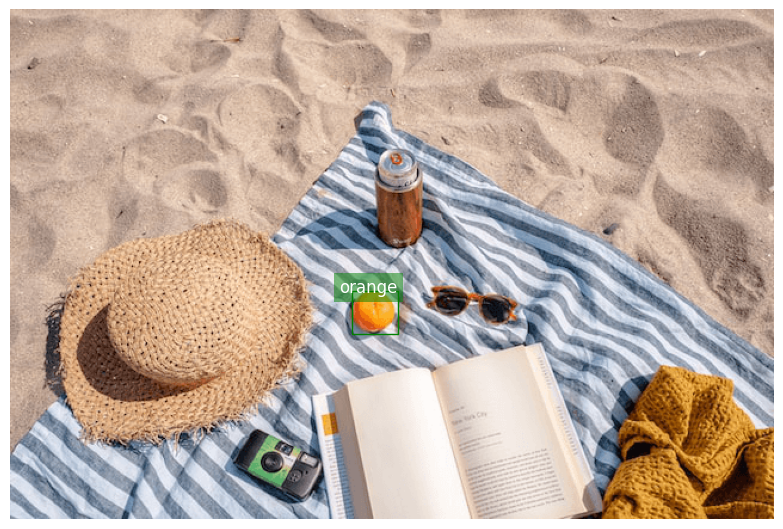

Detecting drink...


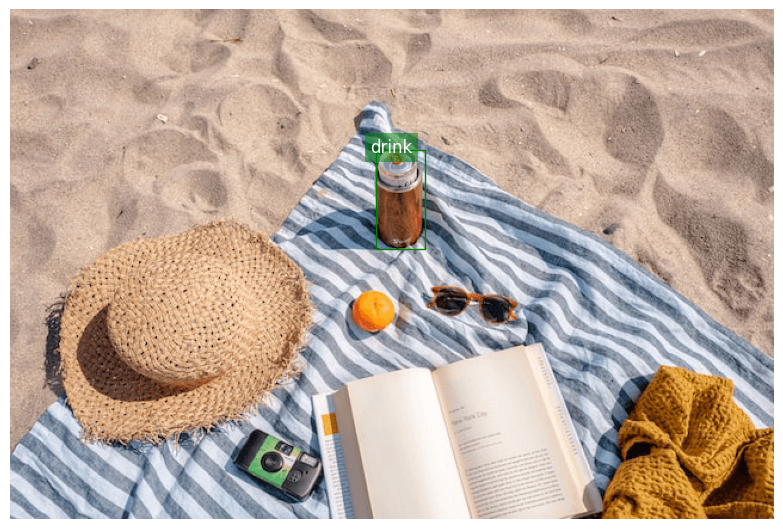

Detecting scarf...


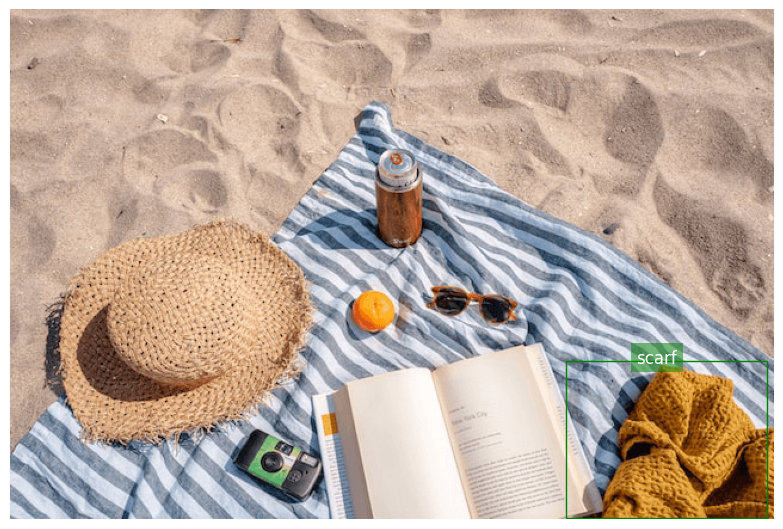

In [15]:
matched_boxes = []
for label, prompts in label_prompts.items():
    print(f"Detecting {label}...")
    pred_box = detect_object_coordinates(
        clip_model,
        clip_preprocess,
        prompts,
        image_pt,
        candidate_boxes,
    )
    matched_boxes.append(pred_box)
    plot_image_with_boxes(image, [pred_box], [label])

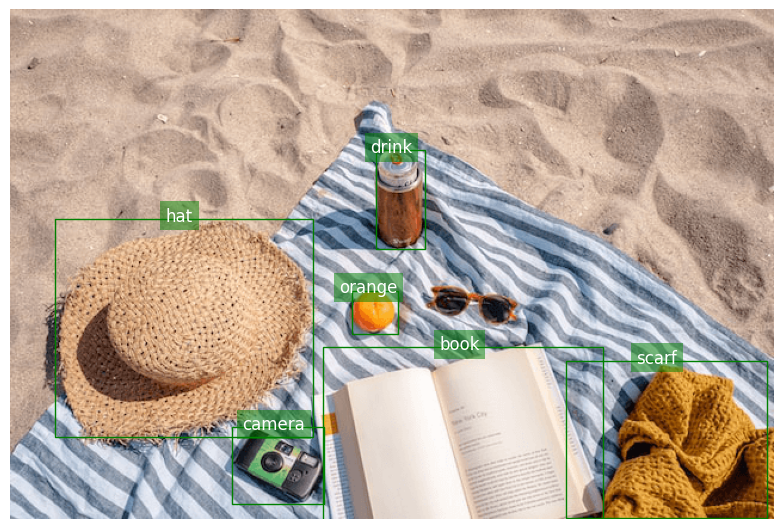

In [16]:
plot_image_with_boxes(image, matched_boxes, labels)